In [2]:
import pandas as pd
import json

In [3]:
path = "/home/ikharitonov/Desktop/data/connectivity/connectivity_target_experiment_lists/"

In [4]:
main_structure = "RSPagl"
df = pd.read_csv(path+main_structure+".csv")
df

,id,transgenic-line,product-id,structure-id,structure-abbrev,structure-name,name,injection-volume,injection-structures,gender,strain,sum,structure-color,num-voxels,injection-coordinates,selected,experiment_page_url
0,512314723,Emx1-IRES-Cre,35,533,VISpm,posteromedial visual area,Emx1-IRES-Cre-234273,0.275993,"[{""id""=>385, ""abbreviation""=>""VISp"", ""name""=>""...",M,NaN,5.082025e-01,08858c,NaN,"[8480, 510, 4080]",False,http://connectivity.brain-map.org/projection/e...
1,267608343,Prkcd-GluCla-CFP-IRES-Cre,5,155,LD,Lateral dorsal nucleus of thalamus,Prkcd-GluCla-CFP-IRES-Cre-125,0.299917,"[{""id""=>155, ""abbreviation""=>""LD"", ""name""=>""La...",F,C57BL/6J,3.815785e-01,ff909f,NaN,"[6870, 2780, 7060]",False,http://connectivity.brain-map.org/projection/e...
2,571100135,Emx1-IRES-Cre,36,394,VISam,Anteromedial visual area,Emx1-IRES-Cre-294569,0.518470,"[{""id""=>394, ""abbreviation""=>""VISam"", ""name""=>...",M,NaN,3.743496e-01,08858c,NaN,"[8180, 570, 4120]",False,http://connectivity.brain-map.org/projection/e...
3,180296424,NaN,5,385,VISp,Primary visual area,378-1815,0.814006,"[{""id""=>385, ""abbreviation""=>""VISp"", ""name""=>""...",M,C57BL/6J,3.645531e-01,08858c,NaN,"[9290, 2220, 9410]",False,http://connectivity.brain-map.org/projection/e...
4,100141796,NaN,5,312782574,VISli,Laterointermediate area,378-796,0.178562,"[{""id""=>409, ""abbreviation""=>""VISl"", ""name""=>""...",M,C57BL/6J,3.644571e-01,08858c,NaN,"[9180, 2370, 9440]",False,http://connectivity.brain-map.org/projection/e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,304337288,Th-Cre_FI172,5,749,VTA,Ventral tegmental area,Th-Cre_FI172-135967,0.010615,"[{""id""=>128, ""abbreviation""=>""MRN"", ""name""=>""M...",F,B6.FVB,1.089119e-07,ff90ff,NaN,"[8410, 4830, 6180]",False,http://connectivity.brain-map.org/projection/e...
2895,125831616,NaN,5,951,PYR,Pyramus (VIII),378-1265,0.157833,"[{""id""=>944, ""abbreviation""=>""FOTU"", ""name""=>""...",M,C57BL/6J,9.928820e-08,fffc91,NaN,"[12830, 3150, 6300]",False,http://connectivity.brain-map.org/projection/e...
2896,277854916,Erbb4-T2A-CreERT2,5,693,VMH,Ventromedial hypothalamic nucleus,Erbb4-2A-CreERT2-D-5769,0.502381,"[{""id""=>1, ""abbreviation""=>""TMv"", ""name""=>""Tub...",M,C57BL/6J,3.300412e-08,ff4c3e,NaN,"[7350, 6660, 6370]",False,http://connectivity.brain-map.org/projection/e...
2897,310695955,Crh-IRES-Cre_ZJH,5,679,CS,Superior central nucleus raphe,Crh-IRES-Cre-125986,0.007551,"[{""id""=>146, ""abbreviation""=>""PRNr"", ""name""=>""...",F,C57BL/6J,2.488443e-08,ffc395,NaN,"[9830, 5230, 6000]",False,http://connectivity.brain-map.org/projection/e...


### Grouping experiments by injection volume

array([[<AxesSubplot:title={'center':'injection-volume'}>]], dtype=object)

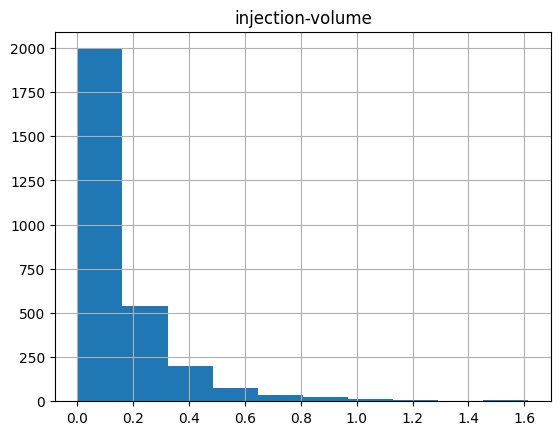

In [5]:
df.hist("injection-volume")

In [6]:
sorted_df = df.sort_values("injection-volume", ascending=False).head(10)
sorted_df

,id,transgenic-line,product-id,structure-id,structure-abbrev,structure-name,name,injection-volume,injection-structures,gender,strain,sum,structure-color,num-voxels,injection-coordinates,selected,experiment_page_url
95,512315551,Emx1-IRES-Cre,36,385,VISp,Primary visual area,Emx1-IRES-Cre-234272,1.614223,"[{""id""=>385, ""abbreviation""=>""VISp"", ""name""=>""...",M,NaN,0.132736,08858c,NaN,"[8460, 1630, 2340]",False,http://connectivity.brain-map.org/projection/e...
2226,267703239,Slc6a5-Cre_KF109,5,1048,GRN,Gigantocellular reticular nucleus,Slc6a5-Cre_KF109-2996,1.547006,"[{""id""=>136, ""abbreviation""=>""IRN"", ""name""=>""I...",F,C57BL/6J,0.000055,ffb3d9,NaN,"[11450, 5880, 5690]",False,http://connectivity.brain-map.org/projection/e...
708,181057754,NaN,5,88,AHN,Anterior hypothalamic nucleus,378-1838,1.523724,"[{""id""=>15, ""abbreviation""=>""PT"", ""name""=>""Par...",M,C57BL/6J,0.006752,ff4c3e,NaN,"[6240, 5860, 6320]",False,http://connectivity.brain-map.org/projection/e...
1032,158258062,NaN,5,693,VMH,Ventromedial hypothalamic nucleus,378-1627,1.465075,"[{""id""=>1, ""abbreviation""=>""TMv"", ""name""=>""Tub...",M,C57BL/6J,0.001544,ff4c3e,NaN,"[6610, 6100, 6390]",False,http://connectivity.brain-map.org/projection/e...
35,174957972,NaN,5,181,RE,Nucleus of reuniens,378-1773,1.457846,"[{""id""=>15, ""abbreviation""=>""PT"", ""name""=>""Par...",M,C57BL/6J,0.196624,ff909f,NaN,"[6010, 4350, 5520]",False,http://connectivity.brain-map.org/projection/e...
182,158257355,NaN,5,596,NDB,Diagonal band nucleus,378-1626,1.414942,"[{""id""=>48, ""abbreviation""=>""ACAv"", ""name""=>""A...",M,C57BL/6J,0.079826,96a7d3,NaN,"[4620, 6410, 5620]",False,http://connectivity.brain-map.org/projection/e...
2208,180674463,NaN,5,88,AHN,Anterior hypothalamic nucleus,378-1837,1.399506,"[{""id""=>30, ""abbreviation""=>""PVa"", ""name""=>""Pe...",M,C57BL/6J,0.000057,ff4c3e,NaN,"[6250, 6200, 6520]",False,http://connectivity.brain-map.org/projection/e...
1439,159024474,NaN,5,395,MDRN,Medullary reticular nucleus,378-1661,1.305444,"[{""id""=>135, ""abbreviation""=>""AMB"", ""name""=>""N...",M,C57BL/6J,0.000342,ffb3d9,NaN,"[12020, 6740, 6940]",False,http://connectivity.brain-map.org/projection/e...
1199,180917660,NaN,5,677,VISC,Visceral area,378-1826,1.298801,"[{""id""=>111, ""abbreviation""=>""AIp"", ""name""=>""A...",M,C57BL/6J,0.000786,11ad83,NaN,"[6370, 4320, 10280]",False,http://connectivity.brain-map.org/projection/e...
2361,300691325,Slc6a5-Cre_KF109,5,1093,PRNc,"Pontine reticular nucleus, caudal part",Slc6a5-Cre_KF109-3010,1.242251,"[{""id""=>136, ""abbreviation""=>""IRN"", ""name""=>""I...",M,C57BL/6J,0.000041,ffba86,NaN,"[10060, 5880, 7270]",False,http://connectivity.brain-map.org/projection/e...


### Grouping experiments by expression (density/energy/intensity) in target

In [7]:
from allensdk.api.queries.rma_api import RmaApi
rma = RmaApi()

def query_structure_id(structure_acronym):
    query = rma.model_query('StructureLookup', criteria="structure[acronym$eq"+structure_acronym+"]",include="structure")[0]
    return query['structure']['id']

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache()

In [8]:
main_structure_id = query_structure_id(main_structure)

In [9]:
# structure_unionizes = mcc.get_structure_unionizes([e['id'] for e in sorted_df])
structure_unionizes = mcc.get_structure_unionizes([sorted_df["id"].iloc[1]])
structure_unionizes.head()

,experiment_id,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
0,267703239,2,631113803,False,0.362904,8010,1960,6500,0.000157,0.000210,0.163893,781.088074,0.000243,502,2.972735e+11,9.440073e+08,1.547162e+08,1.980778e+05,1.156409
1,267703239,3,631116368,False,0.988108,12480,5970,4090,0.115131,0.096109,124.863612,1299.190244,0.178108,429,5.782214e+11,1.512812e+09,1.888951e+11,1.453945e+08,1.853194
2,267703239,1,631115197,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,778,2.822128e+11,6.987096e+08,0.000000e+00,0.000000e+00,0.855919
3,267703239,2,631114123,True,0.998328,11420,5680,5720,0.000725,0.545038,2354.677002,4320.210449,0.001122,832,4.817550e+09,1.680459e+06,3.956939e+09,9.159135e+05,0.002059
4,267703239,3,631116819,False,1.000000,11370,6080,4410,0.659564,0.430748,1813.103852,4209.203012,1.020349,852,4.328941e+12,1.933704e+09,3.506005e+12,8.329381e+08,2.368787


In [10]:
target_unionized_data = structure_unionizes[structure_unionizes["structure_id"]==query_structure_id("RSPagl")]
target_unionized_data

,experiment_id,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
94,267703239,1,631115084,False,0.100236,7150,270,4540,0.000019,0.000023,0.005866,259.996095,0.000029,894,3.299496e+11,1.060688e+09,6222288.0,23932.236328,1.299343
1478,267703239,2,631114193,False,0.107983,9730,910,6760,0.000017,0.000020,0.006143,312.554768,0.000026,894,3.276163e+11,1.060688e+09,6515861.0,20847.101562,1.299343
2277,267703239,3,631116857,False,0.107983,9730,910,6760,0.000035,0.000021,0.006005,284.464880,0.000055,894,6.575660e+11,2.121376e+09,12738149.0,44779.337891,2.598685


In [11]:
df[df["id"]==target_unionized_data["experiment_id"].unique()[0]]["injection-structures"].item()

'[{"id"=>136, "abbreviation"=>"IRN", "name"=>"Intermediate reticular nucleus", "color"=>"FFB3D9"}, {"id"=>169, "abbreviation"=>"PRP", "name"=>"Nucleus prepositus", "color"=>"FFB3D9"}, {"id"=>202, "abbreviation"=>"MV", "name"=>"Medial vestibular nucleus", "color"=>"FFB3D9"}, {"id"=>225, "abbreviation"=>"SPIV", "name"=>"Spinal vestibular nucleus", "color"=>"FFB3D9"}, {"id"=>307, "abbreviation"=>"MARN", "name"=>"Magnocellular reticular nucleus", "color"=>"FFB3D9"}, {"id"=>651, "abbreviation"=>"NTS", "name"=>"Nucleus of the solitary tract", "color"=>"FFA5D2"}, {"id"=>852, "abbreviation"=>"PARN", "name"=>"Parvicellular reticular nucleus", "color"=>"FFB3D9"}, {"id"=>970, "abbreviation"=>"PGRNd", "name"=>"Paragigantocellular reticular nucleus, dorsal part", "color"=>"FFB3D9"}, {"id"=>978, "abbreviation"=>"PGRNl", "name"=>"Paragigantocellular reticular nucleus, lateral part", "color"=>"FFB3D9"}, {"id"=>1048, "abbreviation"=>"GRN", "name"=>"Gigantocellular reticular nucleus", "color"=>"FFB3D9"}

In [12]:
# using this approach, unionized data would have to be downloaded for every experiment (might take a lot of time e.g. 1855 experiments for RSPagl), only then filtered by expression values

In [13]:
# solution: https://allensdk.readthedocs.io/en/latest/_modules/allensdk/api/queries/mouse_connectivity_api.html#MouseConnectivityApi.get_structure_unionizes

In [14]:
pd.DataFrame(rma.model_query("ProjectionStructureUnionize", criteria="section_data_set[id$eq512315551]", include="structure[id$eq894]"))

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,section_data_set_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume,structure
0,2,640689589,False,0.696321,6920,350,6900,0.013240,0.016449,9.820845,597.049358,0.021373,512315551,894,1.216443e+11,1.060688e+09,1.041685e+10,1.744722e+07,1.299343,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."
1,1,640690929,True,1.000000,10220,1590,3510,0.056853,0.999967,12032.166605,12032.561016,0.091773,512315551,894,9.014689e+11,7.491925e+07,9.014408e+11,7.491679e+07,0.091776,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."
2,1,640690930,False,1.000000,9720,1630,3410,0.068989,0.099411,206.254527,2074.762553,0.111363,512315551,894,3.327241e+11,9.144732e+08,1.886142e+11,9.090883e+07,1.120230,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."
3,3,640692609,True,1.000000,10220,1590,3510,0.056853,0.999967,12032.166605,12032.561016,0.091773,512315551,894,9.014689e+11,7.491925e+07,9.014408e+11,7.491679e+07,0.091776,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."
4,3,640692612,False,1.000000,9720,1630,3410,0.082229,0.054859,100.767021,1836.824888,0.132736,512315551,894,4.543683e+11,1.975161e+09,1.990311e+11,1.083561e+08,2.419572,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."


In [15]:
import time
start = time.time()
# for e in df["id"]: print(pd.DataFrame(rma.model_query("ProjectionStructureUnionize", criteria="section_data_set[id$eq"+str(e)+"]", include="structure[id$eq"+str(query_structure_id("RSPagl"))+"]"))["projection_density"].mean())
print("elapsed seconds =",time.time()-start)

elapsed seconds = 6.532669067382812e-05


### Goal: Get the list of all brain areas, choose experiments with injections in each brain area which project to V2m structures (above), filter out structures where injection sites include target area, from these experiments get structure unionize data at each V2m area [repeat for every brain area]

In [16]:
struct_set_id = 167587189 # Curated list of non-overlapping substructures at a mid-ontology level

In [17]:
# coarse_set_list = structure_tree.get_structures_by_set_id([SET_ID])
struct_set = pd.DataFrame(rma.model_query('Structure', criteria="structure_sets[id$eq"+str(struct_set_id)+"]", start_row=0, num_rows='all'))
struct_set

,acronym,atlas_id,color_hex_triplet,depth,failed,failed_facet,graph_id,graph_order,hemisphere_id,id,...,neuro_name_structure_id,neuro_name_structure_id_path,ontology_id,parent_structure_id,safe_name,sphinx_id,st_level,structure_id_path,structure_name_facet,weight
0,PAG,240.0,FF90FF,5,False,734881840,1,838,3,795,...,None,None,1,323,Periaqueductal gray,839,8,/997/8/343/313/323/795/,3260726339,8690
1,ARH,27.0,FF5D50,6,False,734881840,1,733,3,223,...,None,None,1,157,Arcuate hypothalamic nucleus,734,8,/997/8/343/1129/1097/157/223/,218062747,8690
2,ORBm,232.0,248A5E,7,False,734881840,1,264,3,731,...,None,None,1,714,Orbital area medial part,265,9,/997/8/567/688/695/315/714/731/,3012751712,8690
3,LSv,174.0,90CBED,7,False,734881840,1,589,3,266,...,None,None,1,242,Lateral septal nucleus ventral part,590,9,/997/8/567/623/477/275/242/266/,1660459064,8690
4,PD,255.0,FF5547,6,False,734881840,1,746,3,914,...,None,None,1,141,Posterodorsal preoptic nucleus,747,8,/997/8/343/1129/1097/141/914/,2759126254,8690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,SSp-bfd,748.0,188064,8,False,734881840,1,51,3,329,...,None,None,1,322,Primary somatosensory area barrel field,52,9,/997/8/567/688/695/315/453/322/329/,3406319794,8690
312,OT,235.0,80CDF8,6,False,734881840,1,577,3,754,...,None,None,1,493,Olfactory tubercle,578,8,/997/8/567/623/477/493/754/,1598442672,8690
313,SubG,464.0,FF909F,7,False,734881840,1,710,3,321,...,None,None,1,1014,Subgeniculate nucleus,711,8,/997/8/343/1129/549/856/1014/321/,3545734096,8690
314,SNr,330.0,FF90FF,5,False,734881840,1,822,3,381,...,None,None,1,323,Substantia nigra reticular part,823,8,/997/8/343/313/323/381/,1375238552,8690


In [18]:
# Number of experiments from injections across all brain areas targeting RSPagl
total_num_collected_exps = 0
area_experiment_id_dict = {}

for area_id in struct_set['id']:
    total_num_collected_exps += len(df[df['structure-id']==area_id])
    area_experiment_id_dict[area_id] = list(df[df['structure-id']==area_id]['id'])
    # print("Experiments in area",struct_set[struct_set['id']==area_id]['acronym'].item(),"=", len(df[df['structure-id']==area_id]))
print(total_num_collected_exps)
print(area_experiment_id_dict)

2899
{795: [300076066, 272699357, 267029447, 287247978, 266500714, 496114558, 272829745, 120761491, 266099165, 156979283, 302053755, 162020630, 287712779, 182144176, 301540850, 300166697, 160538548, 158376179, 147635309, 113096571, 300111793, 128002057, 120571672, 180524412, 298079928, 182280207, 304949216, 262188772, 299856390, 267030155, 301671287, 301541824, 543880631, 114155923, 292624169], 223: [263369222, 171482142, 175738378, 146554676, 241278553, 178282527, 286726777, 232311236, 181891892, 158142090, 286318327, 176431817, 146660999, 232310521, 586447435, 298105299, 159751184], 731: [478582494, 272781246, 126860974, 496554237, 475617622, 293471629, 539519329, 292477301, 258916270, 524267323, 159209586, 277956496, 286648290, 265820216, 277855624], 266: [303537993, 167654731, 182887258, 113783321], 914: [], 207: [], 1049: [304997333], 609: [], 35: [177460028, 311845265], 425: [593277684, 591224520, 555745687, 571410278, 286417464, 272916202, 568502684, 584651014, 299828473, 553743

In [19]:
# df[df['structure-id']==795]['injection-structures'].iloc[0]

In [20]:
# # make a copy of experiment df
# unmatched_df = df.copy()
# num_collected_exps = 0

# # loop through brain areas, removing experiments successfully matching with an area
# for area_id in struct_set['id']:
#     indexes_to_drop = df.index[df['structure-id']==area_id]
#     num_collected_exps += len(indexes_to_drop)
#     unmatched_df = unmatched_df.drop(indexes_to_drop)
#     # if area_id == 329: break

# # display df with unmatched experiments
# print(num_collected_exps)
# unmatched_df

In [22]:
# Filtering out experiments with overlapping injection and target structures

filtered_area_experiment_id_dict = {}
exps_removed = []

for area_id, exps in area_experiment_id_dict.items():
    # if a V2m structure id is contained in injection-structures of an experiment, drop that experiment (id) from area_experiment_id_dict
    exps_ids_to_retain = []
    for exp_id in exps:
        inj_structs_dict = json.loads(df[df['id']==exp_id]['injection-structures'].item().replace("=>",":"))
        inj_structs_id_list = [x['id'] for x in inj_structs_dict]
        if main_structure_id in inj_structs_id_list: exps_removed.append(exp_id)
        else: exps_ids_to_retain.append(exp_id)
        # print(inj_structs_id_list)
        # break
    filtered_area_experiment_id_dict[area_id] = exps_ids_to_retain
print(len(exps_removed),"experiments removed:")
print(exps_removed)

140 experiments removed:
[593277684, 591224520, 297671724, 180720175, 173206592, 126852363, 292124765, 304641170, 299784429, 112595376, 496113850, 292373346, 303784745, 531443949, 176497015, 599076623, 561307215, 606778738, 304694156, 147789031, 305235787, 303535867, 575782182, 646525156, 562674923, 557187751, 646525997, 576341623, 576036240, 112229103, 593018150, 168164230, 617901499, 495345959, 614094233, 553746532, 264249312, 595884140, 557827228, 267032286, 572595932, 604100536, 573331541, 585021827, 595259180, 643635656, 585760423, 599136295, 577298618, 554333581, 288168426, 126862385, 479984127, 113887868, 546103149, 584511827, 512315551, 272782668, 501115762, 536298726, 601476074, 298404860, 554641575, 174361040, 591169915, 603479758, 286302294, 560725737, 510835921, 593016678, 298759552, 517077687, 294484177, 606929366, 268320515, 524666049, 657046319, 574950390, 526502209, 510417993, 510417255, 482640524, 566732238, 523714193, 539514325, 544488252, 514332492, 580150240, 585910

In [23]:
exp_id = 593277684
pd.DataFrame(rma.model_query("ProjectionStructureUnionize", criteria="section_data_set[id$eq"+str(exp_id)+"]", include="structure[id$eq"+str(main_structure_id)+"]"))

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,section_data_set_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume,structure
0,2,641411381,False,0.593377,9930,1960,8290,0.045184,0.011082,8.384654,756.619496,0.014399,593277684,894,1.953943e+11,1.060688e+09,8.893501e+09,1.175426e+07,1.299343,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."
1,1,641412496,True,1.000000,9950,1830,3190,0.104544,0.938834,9171.587892,9769.127795,0.033315,593277684,894,2.672567e+11,2.896785e+07,2.656811e+11,2.719599e+07,0.035486,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."
2,1,641412499,False,1.000000,10200,1900,3190,0.316694,0.085303,210.723933,2470.290880,0.100921,593277684,894,4.037469e+11,9.657851e+08,2.035140e+11,8.238464e+07,1.183087,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."
3,3,641415749,True,1.000000,9950,1830,3190,0.104544,0.938834,9171.587892,9769.127795,0.033315,593277684,894,2.672567e+11,2.896785e+07,2.656811e+11,2.719599e+07,0.035486,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."
4,3,641415750,False,1.000000,10200,1900,3190,0.361878,0.046455,104.816369,2256.320503,0.115320,593277684,894,5.991412e+11,2.026473e+09,2.124075e+11,9.413890e+07,2.482429,"{'acronym': 'RSPagl', 'atlas_id': 394, 'color_..."


In [28]:
df[df['id']==593277684]

,id,transgenic-line,product-id,structure-id,structure-abbrev,structure-name,name,injection-volume,injection-structures,gender,strain,sum,structure-color,num-voxels,injection-coordinates,selected,experiment_page_url
113,593277684,Rbp4-Cre_KL100,35,425,VISpl,Posterolateral visual area,Rbp4-Cre_KL100-315836,0.318671,"[{""id""=>385, ""abbreviation""=>""VISp"", ""name""=>""...",M,NaN,0.11532,08858c,NaN,"[9800, 2260, 2930]",False,http://connectivity.brain-map.org/projection/e...


### Goal: For every brain area compute average projection metric over all relevant injection experiments, include choices for hemisphere, threshold (?), etc

In [42]:
# trying to get the hemisphere of the injection site for each experiment - to make sure the uniuonized data pulled later will be from the same hemisphere as injection

In [68]:
# temp_ids = [x['id'] for x in json.loads(df[df['id']==310695955]['injection-structures'].item().replace("=>",":"))]
# temp_ids

In [69]:
# exp = 310695955
# injection_struct = df[df['id']==exp]['structure-id'].item()
# print(injection_struct)
# exp_data = pd.DataFrame(rma.model_query("ProjectionStructureUnionize", criteria="[is_injection$eqtrue][section_data_set_id$eq"+str(exp)+"]"))
# for i in temp_ids: print(exp_data[exp_data['structure_id']==i])

In [71]:
for area_id, exps in filtered_area_experiment_id_dict.items():
    print(area_id)
    for exp in exps:
        exp_data = pd.DataFrame(rma.model_query("ProjectionStructureUnionize", criteria="[is_injection$eqtrue][section_data_set_id$eq"+str(exp)+"]"))
        print(exp_data[(exp_data['id']==df[df['id']==exp]['structure-id'].item()) & (exp_data['hemisphere_id'] != 3)]['hemisphere_id'].item())
    print("===")

795


ValueError: can only convert an array of size 1 to a Python scalar

In [40]:
# for area, exps in filtered_area_experiment_id_dict.items():
#     for exp in exps:
        
#         unionize_data = pd.DataFrame(rma.model_query("ProjectionStructureUnionize", criteria="section_data_set[id$eq"+str(exp)+"]", include="structure[id$eq"+str(main_structure_id)+"]"))
#         print(len(unionize_data))

### Goal: compute centre of mass location, display the average datapoint in brainrender